In [1]:
required_packages <- c("plgp", "lhs", "mvtnorm", "laGP", "mda")
install.packages(setdiff(required_packages, rownames(installed.packages())))

In [2]:
library(plgp)
library(lhs)
library(mvtnorm)
library(laGP)
library(mda)

Loading required package: mvtnorm

Loading required package: tgp


Attaching package: ‘laGP’


The following object is masked from ‘package:plgp’:

    distance


Loading required package: class

Loaded mda 0.5-2




gpiso,ars,gpsep,laGP
0.201,0.002,1.529,0.247
0.161,0.003,1.752,0.274
0.100,0.002,1.226,0.224
0.129,0.003,1.272,0.276
0.141,0.003,1.075,0.190
0.134,0.002,1.009,0.247
0.112,0.003,1.167,0.278
0.129,0.003,0.805,0.212
0.105,0.001,1.123,0.274
0.144,0.003,1.218,0.247


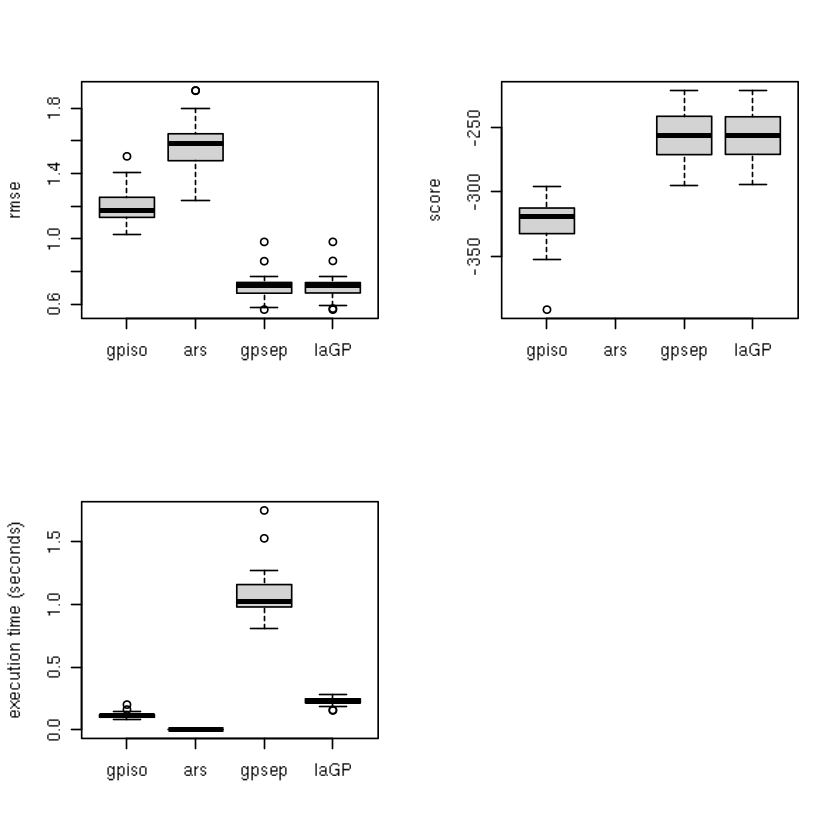

In [3]:
## --------------------------------------------------------------------
fried <- function(n=50, m=6)
 {
  if(m < 5) stop("must have at least 5 cols")
  X <- randomLHS(n, m)
  Ytrue <- 10*sin(pi*X[,1]*X[,2]) + 20*(X[,3] - 0.5)^2 + 10*X[,4] + 5*X[,5]
  Y <- Ytrue + rnorm(n, 0, 1)
  return(data.frame(X, Y, Ytrue))
 }


## --------------------------------------------------------------------
score <- function(Y, mu, Sigma, mah=FALSE)
 {
  Ymmu <- Y - mu
  Sigmai <- solve(Sigma)
  mahdist <- t(Ymmu) %*% Sigmai %*% Ymmu
  if(mah) return(sqrt(mahdist))
  return (- determinant(Sigma, logarithm=TRUE)$modulus - mahdist)
 }


## --------------------------------------------------------------------
nl <- function(par, D, Y) 
 {
  theta <- par[1]                                       ## change 1
  g <- par[2]
  n <- length(Y)
  K <- exp(-D/theta) + diag(g, n)                       ## change 2
  Ki <- solve(K)
  ldetK <- determinant(K, logarithm=TRUE)$modulus
  ll <- - (n/2)*log(t(Y) %*% Ki %*% Y) - (1/2)*ldetK
  counter <<- counter + 1
  return(-ll)
 }


## --------------------------------------------------------------------
gradnl <- function(par, D, Y)
 {
  ## extract parameters
  theta <- par[1]
  g <- par[2]

  ## calculate covariance quantities from data and parameters
  n <- length(Y)
  K <- exp(-D/theta) + diag(g, n)
  Ki <- solve(K)
  dotK <- K*D/theta^2
  KiY <- Ki %*% Y

  ## theta component
  dlltheta <- (n/2) * t(KiY) %*% dotK %*% KiY / (t(Y) %*% KiY) - 
    (1/2)*sum(diag(Ki %*% dotK))

  ## g component
  dllg <- (n/2) * t(KiY) %*% KiY / (t(Y) %*% KiY) - (1/2)*sum(diag(Ki))
    
  ## combine the components into a gradient vector
  return(-c(dlltheta, dllg))
 }


## --------------------------------------------------------------------
nlsep <- function(par, X, Y) 
 {
  theta <- par[1:ncol(X)]  
  g <- par[ncol(X)+1]
  n <- length(Y)
  K <- covar.sep(X, d=theta, g=g)
  Ki <- solve(K)
  ldetK <- determinant(K, logarithm=TRUE)$modulus
  ll <- - (n/2)*log(t(Y) %*% Ki %*% Y) - (1/2)*ldetK
  counter <<- counter + 1
  return(-ll)
 }


## --------------------------------------------------------------------
gradnlsep <- function(par, X, Y)
 {
  theta <- par[1:ncol(X)]
  g <- par[ncol(X)+1]
  n <- length(Y)
  K <- covar.sep(X, d=theta, g=g) 
  Ki <- solve(K)
  KiY <- Ki %*% Y

  ## loop over theta components
  dlltheta <- rep(NA, length(theta))
  for(k in 1:length(dlltheta)) {
    dotK <- K * distance(X[,k])/(theta[k]^2)
    dlltheta[k] <- (n/2) * t(KiY) %*% dotK %*% KiY / (t(Y) %*% KiY) - 
      (1/2)*sum(diag(Ki %*% dotK))
  }

  ## for g   
  dllg <- (n/2) * t(KiY) %*% KiY / (t(Y) %*% KiY) - (1/2)*sum(diag(Ki))
    
  return(-c(dlltheta, dllg))
 }


## --------------------------------------------------------------------
R <- 30
scores <- rmses <- times <- matrix(NA, nrow=R, ncol=4)
colnames(scores) <- colnames(rmses) <- colnames(times) <- c("gpiso", "ars", "gpsep", "laGP")
m <- 7
n <- 200
eps <- sqrt(.Machine$double.eps)
counter <- 0

for(r in 1:R) {

  ## train-test partition and application of f(x) on both
  data <- fried(2*n, m)
  train <- data[1:n,]
  test <- data[(n + 1):(2*n),]
    
  ## extract data elements from both train and test
  X <- as.matrix(train[,1:m])
  y <- drop(train$Y)
  XX <- as.matrix(test[,1:m])
  yy <- drop(test$Y)            ## for score
  yytrue <- drop(test$Ytrue)    ## for RMSE

  ## isotropic GP fit and predict by hand
  tic <- proc.time()[3]
  D <- distance(X)
  out <- optim(c(0.1, 0.1*var(y)), nl, gradnl, method="L-BFGS-B", 
    lower=eps, upper=c(10, var(y)), D=D, Y=y)
  K <- exp(-D/out$par[1]) + diag(out$par[2], nrow(D))
  Ki <- solve(K)
  tau2hat <- drop(t(y) %*% Ki %*% y / nrow(D))
  DXX <- distance(XX)
  KXX <- exp(-DXX/out$par[1]) + diag(out$par[2], ncol(DXX))
  DX <- distance(XX, X)
  KX <- exp(-DX/out$par[1])
  mup <- KX %*% Ki %*% y
  Sigmap <- tau2hat*(KXX - KX %*% Ki %*% t(KX))
  toc <- proc.time()[3]

  ## calculation of metrics for GP by hand
  rmses[r,1] <- sqrt(mean((yytrue - mup)^2))
  scores[r,1] <- score(yy, mup, Sigmap)
  times[r,1] <- toc - tic

  ## MARS fit, predict, and RMSE calculation (no score)
  tic <- proc.time()[3]
  fit.mars <- mars(X, y)
  p.mars <- predict(fit.mars, XX)
  toc <- proc.time()[3]
  rmses[r,2] <- sqrt(mean((yytrue - p.mars)^2))
  times[r,2] <- toc - tic

  ## separable GP fit and predict by hand
  tic <- proc.time()[3]
  outg <- optim(c(rep(0.1, ncol(X)), 0.1*var(y)), nlsep, gradnlsep, 
    method="L-BFGS-B", lower=eps, upper=c(rep(10, m), var(y)), X=X, Y=y)
  K <- covar.sep(X, d=outg$par[1:m], g=outg$par[m+1])
  Ki <- solve(K)
  tau2hat <- drop(t(y) %*% Ki %*% y / nrow(X))
  KXX <- covar.sep(XX, d=outg$par[1:m], g=outg$par[m+1])
  KX <- covar.sep(XX, X, d=outg$par[1:m], g=0)
  mup2 <- KX %*% Ki %*% y
  Sigmap2 <- tau2hat*(KXX - KX %*% Ki %*% t(KX))
  toc <- proc.time()[3]

  ## calculation of metrics for separable GP by hand
  rmses[r,3] <- sqrt(mean((yytrue - mup2)^2))
  scores[r,3] <- score(yy, mup2, Sigmap2)
  times[r,3] <- toc - tic

  ## laGP based separable GP
  tic <- proc.time()[3]
  gpi <- newGPsep(X, y, d=0.1, g=0.1*var(y), dK=TRUE)
  mle <- mleGPsep(gpi, param="both", tmin=c(eps, eps), tmax=c(10, var(y)))
  p <- predGPsep(gpi, XX)
  deleteGPsep(gpi)
  toc <- proc.time()[3]

  ## calculation of metrics for laGP based separable GP
  rmses[r,4] <- sqrt(mean((yytrue - p$mean)^2))
  scores[r,4] <- score(yy, p$mean, p$Sigma)
  times[r,4] <- toc - tic
}


## --------------------------------------------------------------------
par(mfrow=c(2,2))
boxplot(rmses, ylab="rmse")
boxplot(scores, ylab="score")
boxplot(times, ylab="execution time (seconds)")


## --------------------------------------------------------------------
times